# Tools

## GridSearchCVExplorer

 ### Test 1
 
 - Plots should look the same

In [30]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2

%matplotlib inline

np.random.seed(42)

In [1]:
# UNMODIFIED VERSION
# Authors: Robert McGibbon, Joel Nothman

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

print(__doc__)

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=2, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target)

mean_scores = np.array(grid.cv_results_['mean_test_score'])

Automatically created module for IPython interactive environment


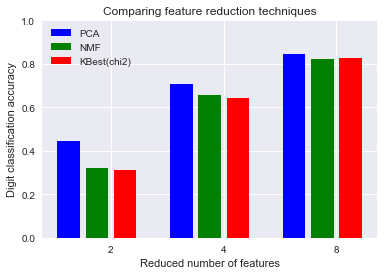

In [33]:
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()

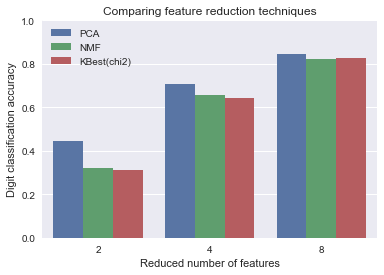

In [35]:
data = pd.DataFrame(mean_scores,
                    index=pd.Index(reducer_labels, name='Reducers'),
                    columns=pd.Index(N_COMPONENTS, name='Num components'))
data = data.stack().reset_index()

ax = sns.barplot(y=0, x='Num components', hue='Reducers', data=data)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

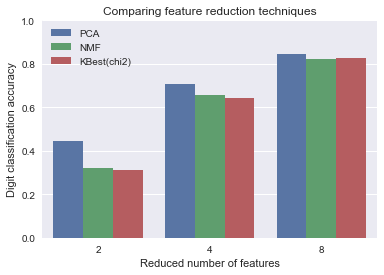

In [36]:
index = pd.MultiIndex.from_product(
    [C_OPTIONS, reducer_labels, N_FEATURES_OPTIONS],
    names=['C',  'Reducers', 'Num components'])

data = pd.Series(mean_scores_flat, index=index,
                 name='mean_test_score').reset_index()
ax = sns.barplot(
    y='mean_test_score', x='Num components', hue='Reducers',
    data=data, estimator=np.max, ci=False)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')

plt.show()

### Test 2

In [69]:
# Adapted from authors: Robert McGibbon, Joel Nothman
# http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

np.random.seed(42)

pipe = Pipeline([
    ('reduce_dim', PCA()),     # will be swapped out with grid search
    ('classify', LinearSVC())  # no tuning, just 'reduce_dim' part
])

C_OPTIONS = [1, 10, 100, 1000]
LOSS_OPTIONS = ['squared_hinge', 'hinge']
N_COMPONENTS = [2, 4, 8]
REDUCERS = [PCA(iterated_power=7), NMF(), TruncatedSVD(),
            TruncatedSVD(algorithm='arpack')]
REDUCER_LABELS = ['PCA', 'NMF', 'TruncatedSVD', 'TruncatedSVD-arpack']
HUE_COLORS = 'bgrcmyk'

param_grid = {
    'reduce_dim': REDUCERS,
    'reduce_dim__n_components': N_COMPONENTS,
    'classify__C': C_OPTIONS,
    'classify__loss': LOSS_OPTIONS
}

grid = GridSearchCV(pipe, cv=3, n_jobs=-1, param_grid=param_grid)
digits = load_digits()
grid.fit(digits.data, digits.target);

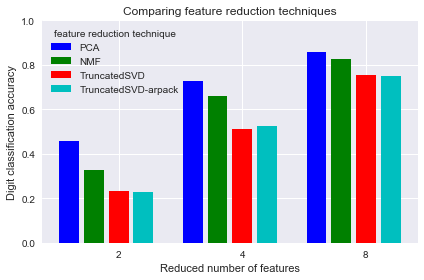

In [38]:
mean_scores_flat = np.array(grid.cv_results_['mean_test_score'])

# Params are ordered alphabetically by str name,
#     then iterated through with itertools.product 
#     for all combinations.
# The order of iteration determines the order of the flattened
#     arrays in grid.cv_results_
# Therefore, best practice is to use same ordering when reshaping.
shape = (
    len(C_OPTIONS),
    len(LOSS_OPTIONS),
    len(REDUCER_LABELS), 
    len(N_COMPONENTS)
)
# mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))

# shape into grid matrix
mean_scores = mean_scores_flat.reshape(*shape)

# select score for best C
mean_scores = mean_scores.max(0).max(0)  # take best params for LinearSVC

bar_offsets = (np.arange(len(N_COMPONENTS)) *
               (len(REDUCER_LABELS) + 1) + 1)

plt.figure()
plt.title("Comparing feature reduction techniques")

# plot each legend group along the x-axis
for i, (label, reducer_scores) in enumerate(zip(REDUCER_LABELS, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores,
            label=label, color=HUE_COLORS[i])

plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(REDUCER_LABELS) / 2, N_COMPONENTS)

plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))

plt.legend(loc='best', title='feature reduction technique')

plt.tight_layout()

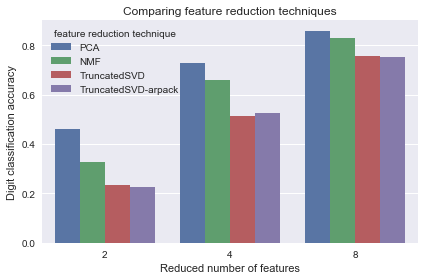

In [42]:
data = pd.DataFrame(mean_scores,
                    index=pd.Index(REDUCER_LABELS, name='Reducers'),
                    columns=pd.Index(N_COMPONENTS, name='Num components'))
data = data.stack().reset_index()

ax = sns.barplot(y=0, x='Num components', hue='Reducers', data=data)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.ylabel('Digit classification accuracy')

plt.legend(loc='best', title='feature reduction technique')

plt.tight_layout()

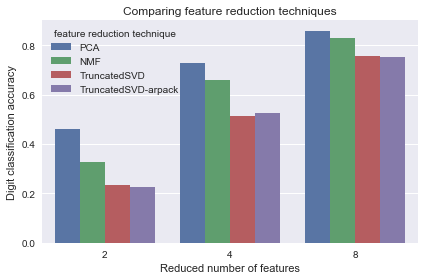

In [43]:
index = pd.MultiIndex.from_product(
    [C_OPTIONS, LOSS_OPTIONS, REDUCER_LABELS, N_COMPONENTS],
    names=['C', 'Loss', 'Reducers', 'Num components'], )

data = pd.Series(mean_scores_flat, index=index,
                 name='mean_test_score').reset_index()
ax = sns.barplot(
    y='mean_test_score', x='Num components', hue='Reducers',
    data=data, estimator=np.max, ci=False)

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.ylabel('Digit classification accuracy')

plt.legend(loc='best', title='feature reduction technique')

plt.tight_layout()

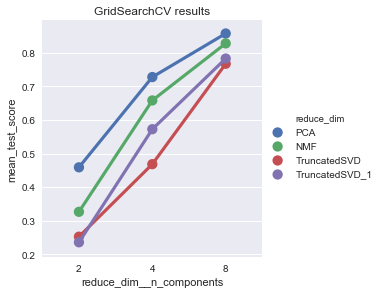

In [83]:
import re

import numpy as np
import pandas as pd
import seaborn as sns


class GridSearchExplorer:
    """Allows explorating of GridSearchCV results with plots."""
    
    
    def __init__(self, grid):
        """Grid instantiated and fit to data.
        
        Note about order of results used for reshaping:
        Grid params are ordered alphabetically by str name,
            then iterated through with itertools.product 
            for all combinations.
        The order of iteration determines the order of the flattened
            arrays in grid.cv_results_
        Therefore, best practice is to use same ordering when reshaping.
        """
        
        self.grid = grid
        self.param_grid = param_grid
        self.param_names = sorted(self.param_grid) 

    def _has_sklearn_base(self, obj):
        return any(str(x).startswith("<class 'sklearn")
                   for x in obj.__class__.__mro__)

    def _param_to_label(self, obj):
        if self._has_sklearn_base(obj):
            pattern = r"[.]([^'.]+)'"
            label = re.search(pattern, str(obj.__class__)).group(1)
        else:
            label = str(obj)

        return label
        
    def _param_grid_to_labels(self, param_vals):
        """df"""
        
        labels = []
       
        for param_group in param_vals:
            group_lbls = []
            i = 0  # dupe label counter
            for val in param_group:
                label = self._param_to_label(val)
                if label in group_lbls:
                    i += 1
                    label = label + '_' + str(i)
                group_lbls.append(label)
                       
            labels.append(group_lbls)

        return labels
        
        
    def plot(self, x, hue, metric='mean_test_score', ax=None, **kwargs):
        
        
        param_keys, param_vals = zip(*sorted(self.param_grid.items()))
        param_grid_labels = self._param_grid_to_labels(param_vals)

        
        index = pd.MultiIndex.from_product(param_grid_labels,
                                           names=param_keys)
        
        scores = self.grid.cv_results_[metric]
        data = pd.Series(scores, index=index,
                         name=metric).reset_index()
#         ax = sns.barplot(
#             y=metric, x=x, hue=hue, data=data,
#             estimator=np.max, ci=False, **kwargs)

        fg = sns.factorplot(
            y=metric, x=x, hue=hue, data=data,
            estimator=np.max, ci=False, ax=ax, **kwargs)

        fg.ax.set_title('GridSearchCV results')
    
        return fg.ax   
    

gx = GridSearchExplorer(grid)
gx.plot(x='reduce_dim__n_components', hue='reduce_dim')

In [ ]:
sns.FacetGrid.ax